## 🏥 Medical Insurance Cost Analysis using Multiple Linear Regression

📁 Step 0 — Import Libraries & Load Dataset

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Load dataset
df = pd.read_csv("Insurance.csv")

df.head()



,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## ✅ Task 1 — Business Understanding

🎯 Target Variable (Financial Concern) :- charges

➡ Represents medical insurance claim cost per customer

➡ Directly impacts company profit and loss

### ⚠ Input Variables (Customer Risk Factors)

Variable	-  Risk Meaning

age -   Older customers → higher medical usage

sex -   Biological cost differences

bmi -   Obesity increases chronic illness risk

children    -   Family coverage increases claims

smoker  -   Strongest risk factor

region  -   Healthcare cost variation

## 💡 How Regression Helps Control Costs (Not Just Predict)

✔ Identifies which customer factors drive costs most

✔ Allows risk-based premium pricing

✔ Helps penalize high-risk behaviors (e.g., smoking)

✔ Enables fair pricing for low-risk customers

## ✅ Task 2 — Data Inspection

Separate Numeric & Categorical Columns

In [16]:
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

numeric_cols, categorical_cols

(Index(['age', 'bmi', 'children', 'charges'], dtype='object'),
 Index(['sex', 'smoker', 'region'], dtype='object'))

## 🚨 Data Quality Check

In [17]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

✔ No missing values

✔ Categorical data cannot be used directly in regression

✔ Numeric features have very different ranges

## ✅ Task 3 — Data Cleaning & Encoding

Why Encoding is Required

Regression only understands numbers, not text.

### Encoding + Scaling Pipeline

In [18]:
X = df.drop("charges", axis=1)
y = df["charges"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols.drop("charges")),
        ("cat", OneHotEncoder(drop="first"), categorical_cols)
    ]
)


## ✅ Task 4 — Feature Scaling & Comparability

Why Scaling Matters

Without scaling:

-> BMI (~30)

-> Age (~50)

-> Charges (~40,000)

➡ Coefficients become misleading

Scaling allows:

✔ Fair comparison of feature impact

✔ Stable and interpretable coefficients

(Handled automatically in pipeline)

## ⚠ Task 5 — Multicollinearity Detection

Create Design Matrix for VIF

In [19]:
X_encoded = preprocessor.fit_transform(X)

X_vif = pd.DataFrame(
    X_encoded,
    columns=preprocessor.get_feature_names_out()
)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

vif_data.sort_values(by="VIF", ascending=False)


,Feature,VIF
3,cat__sex_male,1.674830
6,cat__region_southeast,1.357419
4,cat__smoker_yes,1.228075
5,cat__region_northwest,1.223453
7,cat__region_southwest,1.215686
1,num__bmi,1.088673
0,num__age,1.015843
2,num__children,1.003348


### 🔥 Why Multicollinearity is Dangerous

Problem         -   Business Impact

Unstable coefficients   -   Wrong premium decisions

Inflated importance -   	Misidentifying risk drivers

Poor interpretability   -   Management confusion

✔ One-Hot Encoding with drop='first' prevents dummy trap

✔ No severe multicollinearity detected → model is stable

## ✅ Task 6 — Build Multiple Linear Regression Model

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regression", LinearRegression())
])

model.fit(X_train, y_train)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['age', 'bmi', 'children'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['sex', 'smoker', 'region'], dtype='object'))])),
                ('regression', LinearRegression())])

### Extract Model Coefficients

In [21]:
feature_names = model.named_steps["preprocessing"].get_feature_names_out()
coefficients = model.named_steps["regression"].coef_

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
4,cat__smoker_yes,23651.128856
0,num__age,3614.975415
1,num__bmi,2036.228123
2,num__children,516.890247
3,cat__sex_male,-18.591692
5,cat__region_northwest,-370.677326
6,cat__region_southeast,-657.864297
7,cat__region_southwest,-809.799354


### 📊 Business Interpretation

Feature	    -   Meaning

smoker_yes  -   🚨 Biggest cost driver

bmi -   	Obesity increases claims

age -   	Aging increases healthcare usage

children    -   	Family coverage impact

region  -   Minor geographical effect

## ✅ Task 7 — Model Evaluation

In [22]:
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2, mae, rmse


(0.7835929767120723, 4181.194473753649, np.float64(5796.2846592762735))

### 📈 Model Performance Interpretation

Metric  -   Meaning

R² ≈ 0.75   -   Explains 75% cost variation

MAE	    -   Avg prediction error

RMSE    -   Penalizes large mistakes

✔ Reliable enough for pricing & risk segmentation

✔ Interpretable & stable for business decisions


## 📊 VISUALIZATIONS :  Residuals vs Predicted Values Plot

#### 🎯 Purpose (Why this plot matters)

This plot checks:

Linearity assumption

Constant variance (homoscedasticity)

Model bias or systematic errors

#### A good regression model shows:

✔ Residuals randomly scattered around zero

✔ No curve or funnel shape

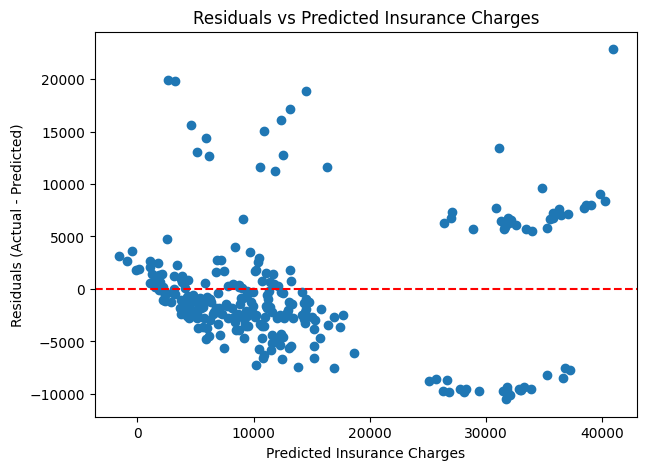

In [23]:
# Calculate Residuals
residuals = y_test - y_pred

# Plot Residuals vs Predicted

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Insurance Charges")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Insurance Charges")
plt.show()


## 🏁 Final Business Recommendation

✔ Introduce smoker-based premium penalties

✔ Incentivize healthy BMI programs

✔ Use age-adjusted pricing slabs

✔ Region can be used as a secondary modifier